# GGIR use case 1

This use case requires the generation of three signals: rest, sleep and main bed period. All signals appear in a time signal between 12:00 noon and 12:00 next day. Each signal consists of two binary signals: period starts and period ends. For reference, there is a larger [description of this use case](https://github.com/sequgen/sequgen/issues/21) as well as a [visualization](https://cran.r-project.org/web/packages/GGIR/vignettes/GGIR.html#42_Output_part_4) of the time signals (click on the tab `4.2.3 visualisation_sleep.pdf`).

## 1. Time axis

We model the time axis as a discrete list of minutes starting at 12\*60 and ending at 36\*60

In [1]:
import numpy as np

time_axis = np.arange(12*60, 36*60+1)

## 2. Channels

We define how many peaks we want, of what width and at what location

In [2]:
import random
from sequgen.dimension import Dimension
from sequgen.parameter_space import ParameterSpace


MAXIMUM_FAILED_TRIES = 100


def peaks_overlap(peaks):
    peaks = peaks_sort(peaks)
    for i in range(0, len(peaks)-1):
        if peaks[i]['location'] + peaks[i]['width'] >= peaks[i+1]['location']:
            return(True)
    return(False)


def peaks_sort(peaks):
    return([ peak for peak in sorted(peaks, key=lambda p:p['location']) ])


def peaks_generate(parameter_space, iterations):
    peaks = []
    failed_tries = 0
    while len(peaks) < iterations and failed_tries < MAXIMUM_FAILED_TRIES:
        new_peak = parameter_space.sample()
        if peaks_overlap(peaks + [new_peak]):
            failed_tries += 1
        else:
            peaks.append(new_peak)
            peaks = peaks_sort(peaks)
            failed_tries = 0
    return peaks

In [3]:
def make_bed_time():
    parameter_space = ParameterSpace([
        Dimension("location", 60*22, 60*26),
        Dimension("width", 60*6, 60*9),
    ])
    bed_time = peaks_generate(parameter_space, 1)
    return(bed_time)

In [4]:
def make_pre_bed_time_rests(bed_time):
    iterations_pre_bed_time = random.randint(0, 5)
    parameter_space = ParameterSpace([
        Dimension("location", time_axis[0], bed_time[0]["location"]),
        Dimension("width", 10, 30),
    ])
    pre_bed_time_rests = peaks_generate(parameter_space, iterations_pre_bed_time)
    return(pre_bed_time_rests)

In [5]:
def make_bed_time_rests(bed_time):
    iterations_bed_time = random.randint(0, 3)
    parameter_space = ParameterSpace([
        Dimension("location", bed_time[0]["location"], bed_time[0]["location"]+bed_time[0]["width"]),
        Dimension("width", 60*2, 60*8),
    ])
    bed_time_rests = peaks_generate(parameter_space, iterations_bed_time)
    return(bed_time_rests)

In [6]:
def make_post_bed_time_rests(bed_time):
    iterations_post_bed_time = random.randint(0, 1)
    parameter_space = ParameterSpace([
        Dimension("location", bed_time[0]["location"]+bed_time[0]["width"], time_axis[-1]),
        Dimension("width", 10, 30),
    ])
    post_bed_time_rests = peaks_generate(parameter_space, iterations_post_bed_time)
    return(post_bed_time_rests)

In [7]:
def make_sleep_periods(pre_bed_time_rests, bed_time_rests, post_bed_time_rests):
    sleep_periods = []
    for rest in pre_bed_time_rests + bed_time_rests + post_bed_time_rests:
        iterations = random.randint(0, 2)
        parameter_space = ParameterSpace([
            Dimension("location", rest["location"], rest["location"]+rest["width"]),
            Dimension("width", 0.5*rest["width"], rest["width"]),
        ])
        sleep_periods.extend(peaks_generate(parameter_space, iterations))
    return(sleep_periods)

In [8]:
def make_signal():
    bed_time = make_bed_time()
    pre_bed_time_rests = make_pre_bed_time_rests(bed_time)
    bed_time_rests = make_bed_time_rests(bed_time)
    post_bed_time_rests = make_post_bed_time_rests(bed_time)
    sleep_periods = make_sleep_periods(pre_bed_time_rests, bed_time_rests, post_bed_time_rests)
    return(bed_time, pre_bed_time_rests, bed_time_rests, post_bed_time_rests, sleep_periods)

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import StepPatch


def make_edges_and_values(periods, height=1):
    values = []
    edges = []
    for period in periods:
        edges.append(period['location'])
        values.append(height)
        edges.append(period['location']+period['width'])
        values.append(0)
    edges.append(edges[-1]+1)
    return(edges, values)

def plot(rest, sleep, bedtime):
    fig, axs = plt.subplots(3, 1, figsize=(10,4))
    edges, values = make_edges_and_values(sleep)
    patch = StepPatch(values=values, edges=edges, color="C2", label="sleep periods")
    axs[0].add_patch(patch)
    axs[0].set_xlim(time_axis[0], time_axis[-1])
    axs[0].set_ylim(0, 2)
    axs[0].tick_params(left=False, labelleft=False)
    axs[0].legend()
    edges, values = make_edges_and_values(rest, height=-1)
    patch = StepPatch(values=values, edges=edges, color="C8", label="rest periods")
    axs[1].add_patch(patch)
    axs[1].set_xlim(time_axis[0], time_axis[-1])
    axs[1].set_ylim(-2, 0)
    axs[1].tick_params(left=False, labelleft=False)
    axs[1].legend()
    edges, values = make_edges_and_values(bed_time)
    patch = StepPatch(values=values, edges=edges, color="C7", label="main bedtime")
    axs[2].add_patch(patch)
    axs[2].set_xlim(time_axis[0], time_axis[-1])
    axs[2].set_ylim(0, 2)
    axs[2].tick_params(left=False, labelleft=False)
    axs[2].legend()
    plt.show()

## Generate and plot

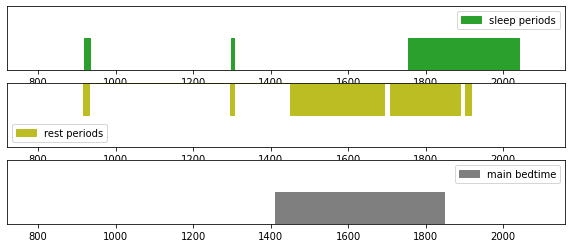

In [10]:
bed_time, pre_bed_time_rests, bed_time_rests, post_bed_time_rests, sleep_periods = make_signal()
plot(pre_bed_time_rests + bed_time_rests + post_bed_time_rests, sleep_periods, bed_time)